# **Clustering - Grupo 03**

## **Authors**

- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310



## **Repositorio**

Esta práctica se ha llevado a cabo en este [repositorio de github](https://github.com/ManuGPR/AA_P2_G03.git)

## **Introducción**

En este cuaderno se resolverá un problema de clustering usando un dataset de estrellas.

# **Carga de dataset**

## **Carga del dataset por drive**

In [1]:
# Para ejecutar el cuaderno en drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
stars = pd.read_csv("/content/drive/MyDrive/stars_data.csv") # acceder al csv en drive

Mounted at /content/drive


## **Carga del dataset en local**

In [2]:
import pandas as pd
stars = pd.read_csv("stars_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'stars_data.csv'

# **1. Dataset**
Este apartado contiene tanto la descripción del dataset como las transformaciones que tendremos que ejecutar antes de trabajar con él.

## **1.1. Descripción del dataset**
Como podemos ver en la salida del código, contamos con un dataset de 240 instancias y 6 características. De estas 6 características, 4 son numéricas y 2 son categóricas.

In [3]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


## **1.2. Transformación de las variables categóricas**
Como se puede observar en la salida del siguiente código, existe un problema con los valores del atributo color. Para esta columna, existen valores que deberían ser iguales, como se puede ver en tipos como "Blue white", "Blue-white" y "Blue-White". Estos valores deberían ser iguales, pero difieren en una mayúscula o en un guión solamente.

In [4]:
stars.Color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

Para arreglarlo, usaremos el siguiente fragmento de código. En él, hacemos un mapeado, donde agrupamos las distintas formas de escribir un valor en una única, para luego sustituir los valores por estas clases mapeadas.

In [5]:
# Mapeado de colores
mapping = {
  "Red": ["Red"],
  "Orange-Red": ["Orange-Red"],
  "Orange": ["Orange"],
  "Yellow-Orange": ["Pale yellow orange"],
  "Yellow": ["yellowish", "Yellowish"],
  "White-Yellow": ["Yellowish White", "yellow-white", "White-Yellow"],
  "White": ["White", "Whitish", "white"],
  "Blue-White": ["Blue White", "Blue white", "Blue-white", "Blue-White"],
  "Blue": ["Blue"],
}

# Cambiamos los colores
for target, source in mapping.items():
  stars.loc[stars.Color.isin(source), 'Color'] = target

stars.Color.unique()

array(['Red', 'Blue-White', 'White', 'White-Yellow', 'Yellow-Orange',
       'Blue', 'Orange', 'Yellow', 'Orange-Red'], dtype=object)

# **2. Conversión de variables categóricas**
Para poder trabajar con los datos necesitamos transformar las columnas categóricas en columnas numéricas. Para esto, las codificaremos mediante *one-hot encoding* y *ordinal-encoding*.

## **2.1. One-Hot Encoding**
La primera manera es hacer un One-Hot Encoding, que es parecido a una transformación a un mapa de bits. Haremos uso de la función `OneHotEncoder` de sklearn.

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Crea el preprocesador
cat_transformer = Pipeline(
  steps= [
    ('onehot', OneHotEncoder())
  ])

# Se crea el transformador
preprocessor = ColumnTransformer(
    transformers = [
      ('cat', cat_transformer, ["Color","Spectral_Class"]),
    ],
    remainder = 'passthrough')
onehot_stars = preprocessor.fit_transform(stars)

# Se consiguen los nombres de las columnas
cat_columns_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=["Color", "Spectral_Class"])
all_columns_names = list(cat_columns_names) + ["Temperature", "L", "R", "A_M"]

# Se consigue el dataframe transformado
onehot_df = pd.DataFrame(onehot_stars, columns=all_columns_names)
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Color_Blue           240 non-null    float64
 1   Color_Blue-White     240 non-null    float64
 2   Color_Orange         240 non-null    float64
 3   Color_Orange-Red     240 non-null    float64
 4   Color_Red            240 non-null    float64
 5   Color_White          240 non-null    float64
 6   Color_White-Yellow   240 non-null    float64
 7   Color_Yellow         240 non-null    float64
 8   Color_Yellow-Orange  240 non-null    float64
 9   Spectral_Class_A     240 non-null    float64
 10  Spectral_Class_B     240 non-null    float64
 11  Spectral_Class_F     240 non-null    float64
 12  Spectral_Class_G     240 non-null    float64
 13  Spectral_Class_K     240 non-null    float64
 14  Spectral_Class_M     240 non-null    float64
 15  Spectral_Class_O     240 non-null    flo

Tras aplicar la transformación vemos que nuestro dataset ha aumentado en dimensionalidad. Esto es lógico ya que esta forma de codificación añade una columna por valor de cada variable categórica. Con esto, nuestro dataset ahora cuenta con 20 columnas, todas de tipo numérico.

## **2.2. Codificación ordinal**
La segunda forma de transformar los datos será mediante una codificación ordinal. Dado que existe una relación de orden entre los valores de las variables categóricas, relacionado con la temperatura de la estrella, hemos establecido nosotros el orden de forma que el valor asignado a las categorías de estrellas más frías se correspondan con los valores más bajos de la codificación ordinal.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# forzar un orden entre categorías y calor
color_categories = ["Red", "Orange-Red", "Orange", "Yellow-Orange", "Yellow", "White-Yellow", "White", "Blue-White", "Blue"]
spectral_categories = ["M", "K", "G", "F", "A", "B", "O"]

# Creamos una instancia de OrdinalEncoder para cada columna que queremos codificar
ordinal_encoder = Pipeline([
    ('ordinal_encoding', OrdinalEncoder(categories=[color_categories, spectral_categories]))
])

# Definimos las columnas que queremos codificar
columns_to_encode = ["Color", "Spectral_Class"]

# Creamos un ColumnTransformer para aplicar el encoder a las columnas seleccionadas
column_transformer = ColumnTransformer(
    transformers = [
      ('ord', ordinal_encoder, columns_to_encode),
    ],
    remainder = 'passthrough')
# Aplicamos la pipeline al DataFrame
ordinal_encoded_data = column_transformer.fit_transform(stars)

ord_columns_names = column_transformer.named_transformers_['ord']['ordinal_encoding'].get_feature_names_out(input_features=["Color", "Spectral_Class"])
all_columns_names = list(ord_columns_names) + ["Temperature", "L", "R", "A_M"]

# Convertimos el resultado a un DataFrame
ordinal_encoded_df = pd.DataFrame(ordinal_encoded_data, columns=all_columns_names)

# Ver los resultados

ordinal_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Color           240 non-null    float64
 1   Spectral_Class  240 non-null    float64
 2   Temperature     240 non-null    float64
 3   L               240 non-null    float64
 4   R               240 non-null    float64
 5   A_M             240 non-null    float64
dtypes: float64(6)
memory usage: 11.4 KB


En este caso, como no se añaden nuevas columnas, la dimensionalidad del dataset se mantiene igual que el original. No obstante, ahora todas las features de tipo numérico.

## **3. PCA**
Para poder realizar correctamente la comparación entre nuestro K_Means y el K_means implementado de scikit-learn, primero deberemos aplicar una reducción de dimensionalidad sobre el data-set. Para ello, usaremos PCA.

Además, para poder comparar la influencia del tipo de codificación en esta operación, se adjunta un gráfico de dispersión comparativo donde podemos comprobar que el hecho de usar ordinal encoding o one-hot encoding sobre este dataset apenas influye sobre el resultado de aplicar PCA.

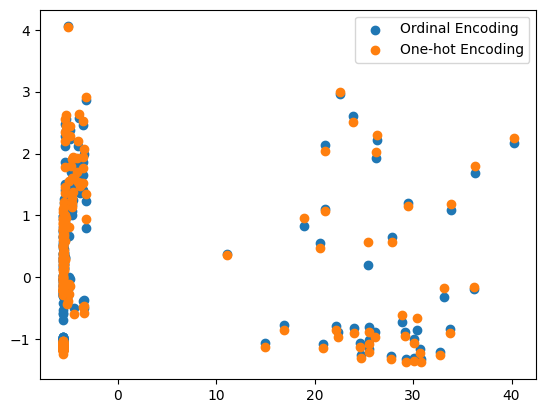

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       240 non-null    float64
 1   1       240 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)

# Escalado de datos
decepticom = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=2))
])

#####

pca_ord_stars = pd.DataFrame(decepticom.fit_transform(ordinal_encoded_df))
pca_ohe_stars = pd.DataFrame(decepticom.fit_transform(onehot_df))
labels = ['Ordinal Encoding', 'One-hot Encoding']
plt.scatter(pca_ord_stars.iloc[:,0], pca_ord_stars.iloc[:, 1], label=labels[0])
plt.scatter(pca_ohe_stars.iloc[:,0], pca_ohe_stars.iloc[:, 1], label=labels[1])

# Añadimos una leyenda
plt.legend()

# Mostramos el plot
plt.show()

pca_ohe_stars.info()



Como resultado de aplicar PCA obtenemos un nuevo dataset de 2 dimensiones. Esto facilita la representación gráfica de las instancias, así como reduce la complejidad de los cálculos. No obstante, esto es a costa de pérdida de información.

# **4. K-Means**
En este apartado, se cubre una implementación propia del algoritmo K-Means, el cuál compararemos luego con el algoritmo de `scikit-learn`

## **4.1. MyK_Means**
Hemos desarrollado una implementación de un algoritmo de clustering Kmeans, contenida en la clase MyKmeans. La implementación se nutre de los módulso pandas y numpy, ya que ofrecen una serie de funcionalidades muy útiles para este tipo de algoritmos.

A continuación se adjunta el código que contiene la implementación del algoritmo.

In [9]:
from random import random
from math import sqrt
import matplotlib.pyplot as plt
import numpy
import sys
import pandas as pd

colors = ['blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink', 'lightblue', 'brown', 'teal', 'lavender', 'olive', 'gray']

class MyK_Means:
  def __init__(self, k: int, data: pd.DataFrame):
    # Número de clusters
    self.k = k

    # Datos sobre los que trabajar
    self.data = data

    # Lista con centroides, index del centroide = value del centroide
    self.centroids = []

    # Lista con los clusters, index del centroide = lista con instancias de esos clusters
    self.past_clusters = []
    self.clusters = []

    # inicializaciones
    self.init_cluster()

    self.init_centroid()
    self.original_centroids = self.centroids.copy()


  @property
  def cluster_labels(self): # lista con a qué cluster pertenece cada instancia
    """
    nos permite calcular el silhouette_score
    """
    out = numpy.array([], dtype=numpy.int32)
    for row in range(len(self.data)):
      closest_centroid = self.calculate_closest_centroid(self.data.iloc[row, :])
      entero = numpy.int32(closest_centroid)
      out = numpy.append(out, [entero,])
    return out

  def init_cluster(self):
    for key in range(self.k):
      self.clusters.append(pd.DataFrame(columns=self.data.columns))

  def init_centroid(self):
    list_min = self.data.min().to_list()
    list_max = self.data.max().to_list()

    for key in range(self.k):
      centroid_list = []
      for column in range(len(self.data.columns)):
        centroid_list.append(random()*(list_max[column] - list_min[column]) + list_min[column])
      self.centroids.append(tuple(centroid_list))

  def calculate_closest_centroid(self, row):
    distances_cluster = []
    for key in range(len(self.centroids)):
      aux = self.calc_distance(self.centroids[key], row)
      if numpy.isnan(aux):
        distances_cluster.append(sys.maxsize)
      else:
        distances_cluster.append(aux)
    return distances_cluster.index(min(distances_cluster))

  def fit(self, showEvolve=False):
    it = 0
    while (True):
      it += 1
      self.past_clusters = []
      for n in range (self.k):
        self.past_clusters.append(self.clusters[n].copy(deep=True))
      self.clusters = []
      self.init_cluster()
      for row in range(len(self.data)):
        closest_centroid = self.calculate_closest_centroid(self.data.iloc[row, :])
        self.clusters[closest_centroid].loc[len(self.clusters[closest_centroid])] = self.data.iloc[row, :]
      if showEvolve:
        for i in range(self.k):
          if len(self.clusters[i]) > 0:
            plt.scatter(self.clusters[i].iloc[0: , 0], self.clusters[i].iloc[0:, 1], color=colors[i], label="datos", s=50)
          #plt.scatter(kmeans_casero.clusters[i].iloc[0: , 0], kmeans_casero.clusters[i].iloc[0:, 1], color="blue", label="datos", s=50)
        plt.scatter(*zip(*self.centroids), color="red", label="destacados", edgecolor='black', s=100)
        plt.show()

      self.recalculate_centroids()

      if (self.check_variation()):
        return it

  @staticmethod
  def calc_distance(vec1, vec2):
    return numpy.linalg.norm(vec1-vec2)

  def recalculate_centroids(self):
    self.centroids = []
    for index in range(len(self.clusters)):
      self.centroids.append(self.clusters[index].mean())

  def check_variation(self):
    for i in range(self.k):
      if not self.clusters[i].equals(self.past_clusters[i]):
        return False
    return True

  def info(self):
    print(">> Nº clusters usados:", self.k)
    for c in self.original_centroids:
      print(c)
    print("=================")
    for c in self.centroids:
      print(f"({c[0]}, {c[1]})")
    print("=================")
    for _ in range(self.k):
      print(f"\tcluster {_}: {len(self.clusters[_])}")




## **4.2. Comparación**
Tras aplicar la transformación de datos, compararemos las implementaciones. Para poder compararlos justamente, es necesario que cuenten ambos con el mismo número de clusters para pobrar, así que probaremos ambas implementaciones con un rango de 2 a 15 clusters.

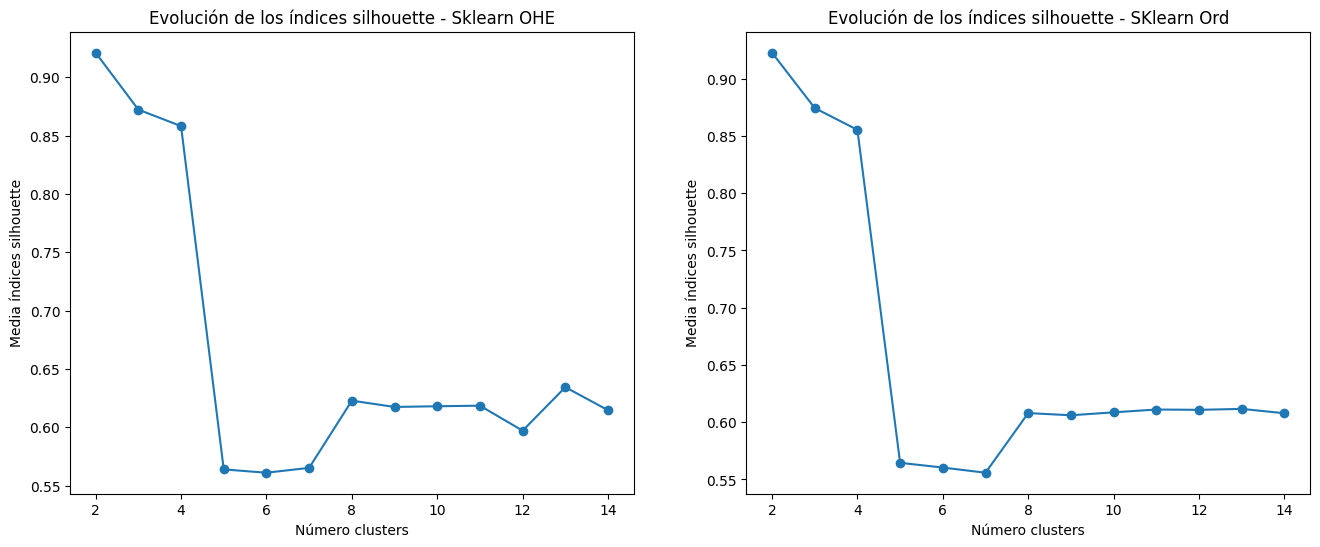

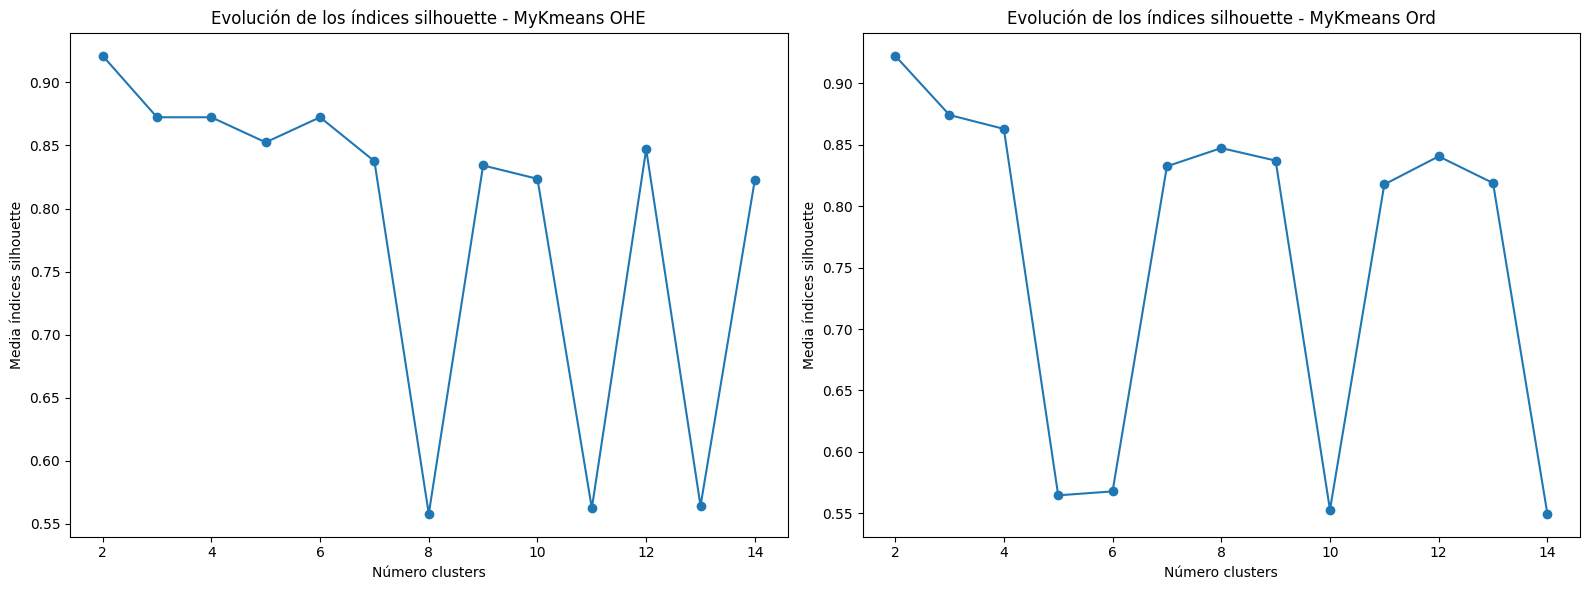

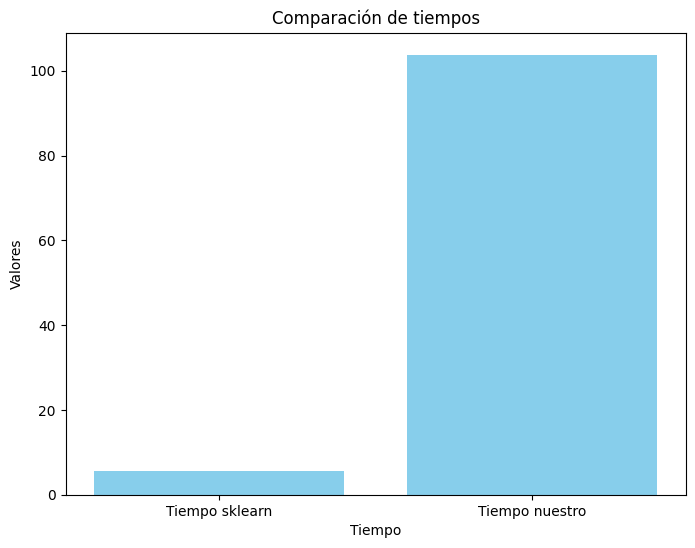

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

start_sklearn = time.time()
# SKlearn ohe
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(pca_ohe_stars)
    silhouette_avg = silhouette_score(pca_ohe_stars, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax[0].set_title("Evolución de los índices silhouette - Sklearn OHE")
ax[0].set_xlabel('Número clusters')
ax[0].set_ylabel('Media índices silhouette')

# sklearn ord_enc
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(pca_ord_stars)
    silhouette_avg = silhouette_score(pca_ord_stars, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)


ax[1].plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax[1].set_title("Evolución de los índices silhouette - SKlearn Ord")
ax[1].set_xlabel('Número clusters')
ax[1].set_ylabel('Media índices silhouette')
end_sklearn = time.time()

# MyKmeans ohe
start_mykmeans = time.time()
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = MyK_Means(
        n_clusters,
        data=pca_ohe_stars
    )
    modelo_kmeans.fit()
    try:
        silhouette_avg = silhouette_score(pca_ohe_stars, modelo_kmeans.cluster_labels)
    except ValueError:
        print("except: se ha usado un único cluster")
        modelo_kmeans.info()
        #print(modelo_kmeans.cluster_labels)
        silhouette_avg = -1
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax[0].set_title("Evolución de los índices silhouette - MyKmeans OHE")
ax[0].set_xlabel('Número clusters')
ax[0].set_ylabel('Media índices silhouette')

# MyKmeans ord_enc
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = MyK_Means(
        n_clusters,
        data=pca_ord_stars
    )
    modelo_kmeans.fit()
    try:
        silhouette_avg = silhouette_score(pca_ord_stars, modelo_kmeans.cluster_labels)
    except ValueError:
        print("except: se ha usado un único cluster")
        modelo_kmeans.info()
        #print(modelo_kmeans.cluster_labels)
        silhouette_avg = -1
    valores_medios_silhouette.append(silhouette_avg)


ax[1].plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax[1].set_title("Evolución de los índices silhouette - MyKmeans Ord")
ax[1].set_xlabel('Número clusters')
ax[1].set_ylabel('Media índices silhouette')
end_mykmeans = time.time()

plt.tight_layout()
plt.show()

# Diagrama de barras del tiempo
plt.figure(figsize=(8, 6))
plt.bar(["Tiempo sklearn", "Tiempo nuestro"], [end_sklearn-start_sklearn, end_mykmeans-start_mykmeans], color='skyblue')

# Adding labels and title
plt.xlabel('Implementaciones')
plt.ylabel('Tiempo (s)')
plt.title('Implementaciones - Tiempo')

# Show plot
plt.show()

# **5. Modelos de clustering**
En este apartado, se cubren dos modelos de clustering, con su posterior análisis y comparación de resultados.

## **5.1. DBSCAN**
El primero modelo de clustering que usaremos es DBSCAN. Para poder tener una mejor solución, usaremos las dos transformaciones de variables categóricas en este modelo, y así luego compararemos cual es la mejor. Además, para reducir el número de instancias ruidosas, se han probado los hiperparámetros eps y min_samples para ver cual ajustaba mejor los datos. El resultado ha sido que en ambos, eps = 10 y min_samples = 1 han obtenido el  mejor `índice de silhouette` con un número de 0 puntos ruidosos cada uno.

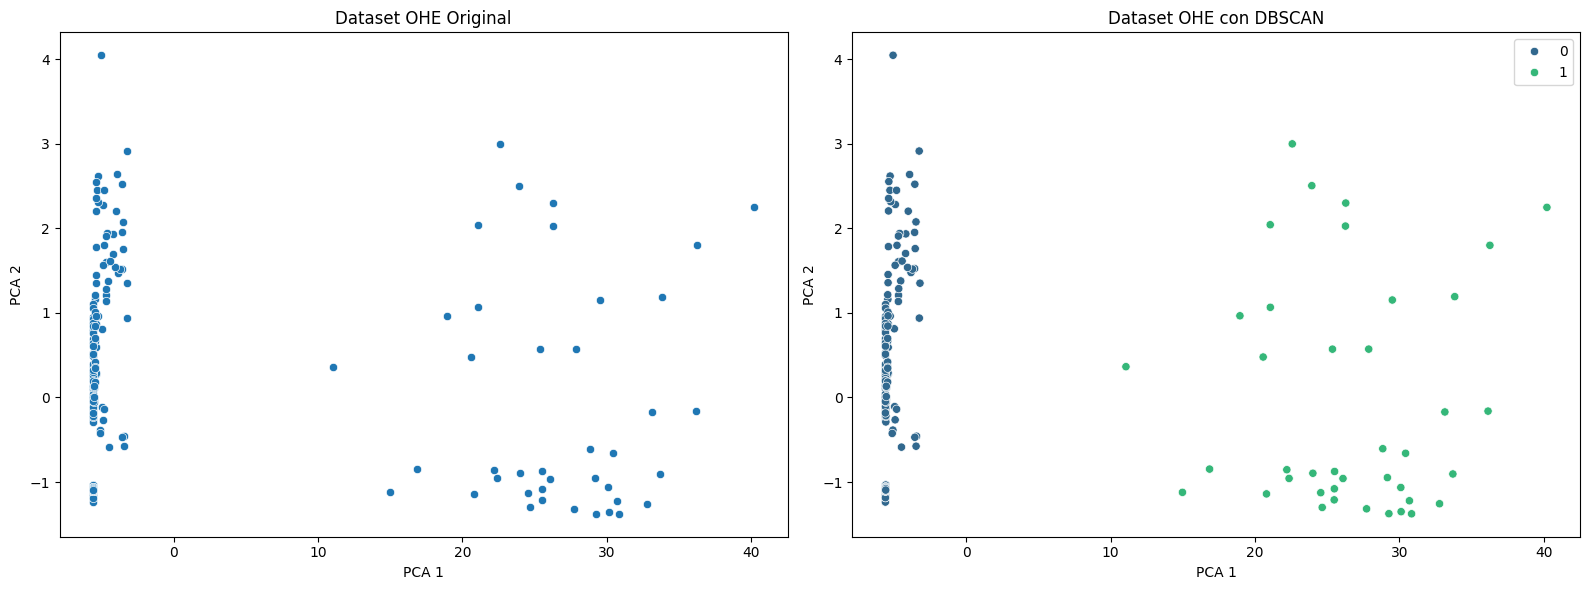

====== Mejor score para DBSCAN con onehot-encoding ======
0.921127149227656


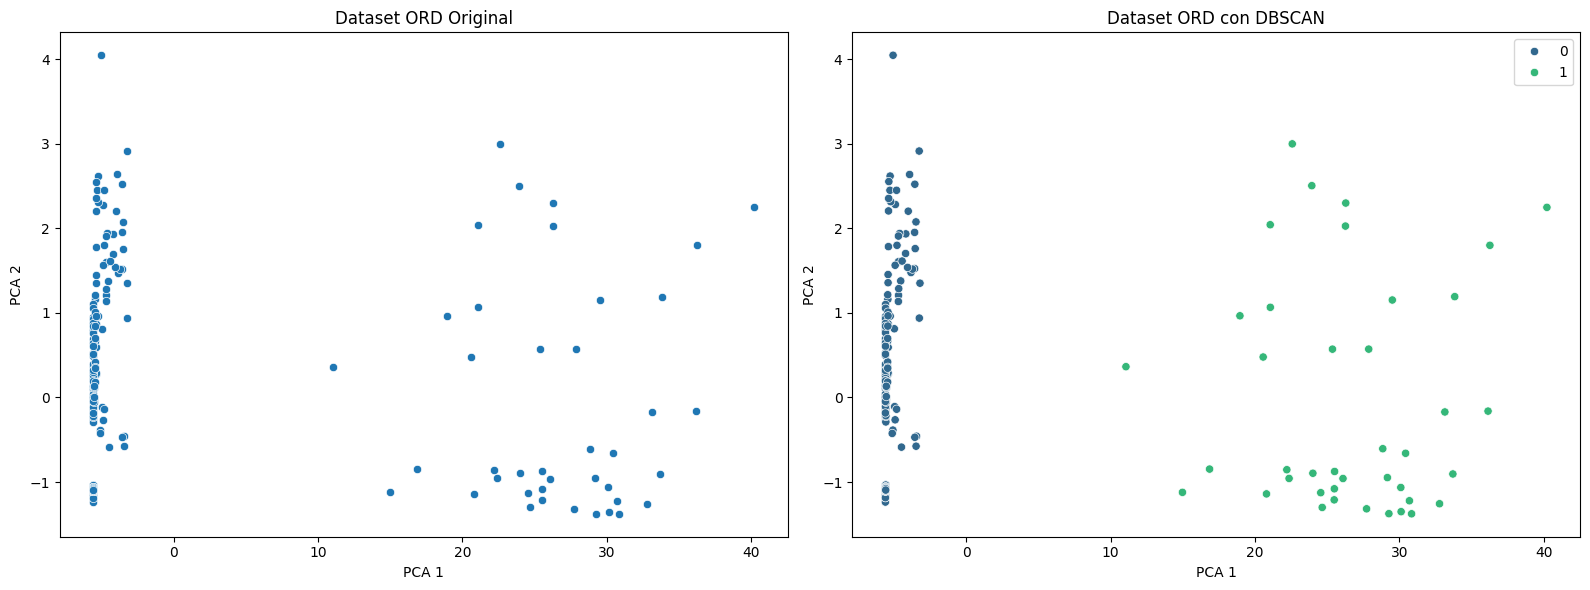

====== Mejor score para DBSCAN con ordinal-encoding ======
0.9225842997233548


In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

#============================== One Hot Encoding ==================================

# Crea una figura
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dataset OHE original
sns.scatterplot(x=pca_ohe_stars.iloc[:, 0], y=pca_ohe_stars.iloc[:, 1], ax=axes[0])
axes[0].set_title('Dataset OHE Original')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# Se crea el modelo
model = DBSCAN(eps=10, min_samples=1)

# Se entrena el modelo con el dataset con onehot-encoding
model.fit(pca_ohe_stars)

# Se guardan los resultados
labels = model.labels_
silhouette_avg = silhouette_score(pca_ohe_stars, labels)

# Se crea un plot con los resultados
sns.scatterplot(x=pca_ohe_stars.iloc[:, 0], y=pca_ohe_stars.iloc[:, 1], hue=labels, palette='viridis', ax=axes[1])
axes[1].set_title('Dataset OHE con DBSCAN')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')

# Se muestar el plot
plt.tight_layout()
plt.show()

# Se imprime la score
print("====== Mejor score para DBSCAN con onehot-encoding ======")
print(silhouette_avg)

#======================= Ordinal Encoding ===================================

# Crea una figura
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dataset ORD original
sns.scatterplot(x=pca_ohe_stars.iloc[:, 0], y=pca_ohe_stars.iloc[:, 1], ax=axes[0])
axes[0].set_title('Dataset ORD Original')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# Se crea el modelo con el dataset con ordinal-encoding
model = DBSCAN(eps=10, min_samples=1)
model.fit(pca_ord_stars)

# Se consiguen los resultados
labels = model.labels_
silhouette_avg = silhouette_score(pca_ord_stars, labels)

# Se crea un plot con los resultados
sns.scatterplot(x=pca_ohe_stars.iloc[:, 0], y=pca_ohe_stars.iloc[:, 1], hue=labels, palette='viridis', ax=axes[1])
axes[1].set_title('Dataset ORD con DBSCAN')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')

# Se muestar el plot
plt.tight_layout()
plt.show()

# Se imprimen los resultados
print("====== Mejor score para DBSCAN con ordinal-encoding ======")
print(silhouette_avg)


Como se puede observar, DBSCAN consigue muy buenos resultados para nuestro dataset, llegando a obtener un `índice de silhouette` cercano a 0.92. Además, la diferencia entre las dos maneras de transformar datos categóricos a numéricos en ínfima, siendo ordinal-encoding ligeramente superior a onehot-encoding, valor que podría alterar con una búsqueda de hiperparámetros más extensa.